## Install the package dependencies before running this notebook

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import matplotlib.pyplot as plt

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [2]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):

    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

## Create a DataLoader class for training

In [3]:
torch.cuda.current_device()

0

In [4]:
!nvidia-smi

Fri May 20 18:41:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.81                 Driver Version: 460.67                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:B1:00.0 Off |                  N/A |
|  0%   32C    P8     7W / 250W |   3125MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
from torch import nn, optim

class Pred(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(100, 512),0
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU()
        )
        
        
        self.decoder = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 120)
        )
        
    def forward(self, x):
        x = x.reshape(-1, 100).float()
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.reshape(-1, 60, 2)
        return x

In [6]:
def train(pred, opt, train_dataset, train_loader, val_dataset, val_loader):
    device = torch.device('cuda:0')
    pred = pred.to(device)
    train_losses = []
    val_losses = []
    
    early_stop_counter = 0
    early_stop_criteria = 25
    dummy = 1
    for epoch in range(120):

        total_loss = 0
        for i_batch, sample_batch in enumerate(train_loader):
            inp, out = sample_batch
            out = out.to(device)
            inp = inp.to(device)
            preds = pred(inp)
            loss = ((preds - out) ** 2).sum()

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()

        val_loss = 0
        for i_batch, sample_batch in enumerate(val_loader):
            inp, out = sample_batch
            out = out.to(device)
            inp = inp.to(device)
            preds = pred(inp)
            #print(preds)
            loss = ((preds - out) ** 2).sum()
            val_loss += loss.item()

        train_loss = np.log(total_loss / len(train_dataset))
        val_loss = np.log(val_loss / len(val_dataset))

        if dummy == 1:
            dummy -= 1
        else: 
            last_valid = val_losses[-1]
            if last_valid < val_loss:
                early_stop_counter += 1
            else:
                pickle.dump(pred, open('models/mlp_9_layer_' + city + '_large', 'wb'))

            if early_stop_counter == early_stop_criteria:
                break
            
        print('epoch {} train_loss: {} val_loss: {}'.format(epoch, train_loss, val_loss))
        train_losses.append(train_loss)
        val_losses.append(val_loss)


    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses, color ="red", label = "train_loss")
    plt.plot(val_losses, color ="blue", label = "val_loss")
    plt.legend()
    plt.show()

city: austin
epoch 0 train_loss: 18.242055848028276 val_loss: 17.141247157197775
epoch 1 train_loss: 17.113357768742397 val_loss: 17.139968653612616
epoch 2 train_loss: 17.11311211567897 val_loss: 17.139646388100044
epoch 3 train_loss: 16.694077131451447 val_loss: 12.994649186645603
epoch 4 train_loss: 12.503588629305181 val_loss: 12.588249986619743
epoch 5 train_loss: 12.168659407669914 val_loss: 12.37513526652536
epoch 6 train_loss: 12.012099530290126 val_loss: 12.159785671891425
epoch 7 train_loss: 11.932499120897864 val_loss: 12.147449027331191
epoch 8 train_loss: 11.909037764384582 val_loss: 12.286739152020598
epoch 9 train_loss: 11.89224958936892 val_loss: 12.250996073685021
epoch 10 train_loss: 11.873738049690235 val_loss: 12.067873826200964
epoch 11 train_loss: 11.87938294966906 val_loss: 11.975121897784618
epoch 12 train_loss: 11.876655327239181 val_loss: 11.935519119225045
epoch 13 train_loss: 11.861064314563674 val_loss: 11.910194473676102
epoch 14 train_loss: 11.84545570979

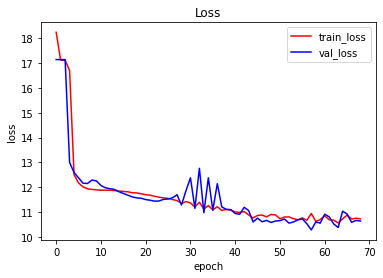

city: miami
epoch 0 train_loss: 19.840968215548134 val_loss: 18.813975691667782
epoch 1 train_loss: 18.152788279687602 val_loss: 16.268597524882715
epoch 2 train_loss: 15.62024071769163 val_loss: 15.560457086039792
epoch 3 train_loss: 14.144350479339735 val_loss: 12.822969696969812
epoch 4 train_loss: 13.49543134791998 val_loss: 13.515922784118525
epoch 5 train_loss: 13.439460549901685 val_loss: 12.606912978323228
epoch 6 train_loss: 13.81797483025612 val_loss: 12.575349155911354
epoch 7 train_loss: 12.775589971154316 val_loss: 12.420309158300205
epoch 8 train_loss: 13.084633417421655 val_loss: 12.324348914021023
epoch 9 train_loss: 12.96186770241586 val_loss: 12.846594950963672
epoch 10 train_loss: 13.042864097994483 val_loss: 12.851406394089391
epoch 11 train_loss: 13.23046615027251 val_loss: 12.089608342036772
epoch 12 train_loss: 12.95813609702774 val_loss: 12.063344347446993
epoch 13 train_loss: 12.602346164673417 val_loss: 12.727483562748422
epoch 14 train_loss: 13.22832101210201

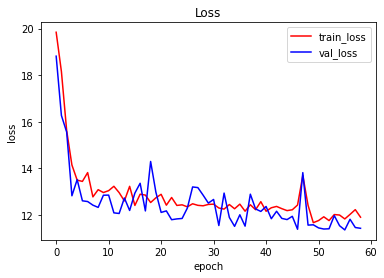

city: pittsburgh
epoch 0 train_loss: 19.347397746890017 val_loss: 17.661263109329145
epoch 1 train_loss: 17.638209166001964 val_loss: 17.66110199932489
epoch 2 train_loss: 17.638385609345953 val_loss: 17.66107027286833
epoch 3 train_loss: 17.638538946767483 val_loss: 17.661057896683726
epoch 4 train_loss: 17.638663945394523 val_loss: 17.661332202339718
epoch 5 train_loss: 17.63878151176916 val_loss: 17.661364646506293
epoch 6 train_loss: 17.638893405789815 val_loss: 17.66115452859431
epoch 7 train_loss: 17.6390246283134 val_loss: 17.66115394758754
epoch 8 train_loss: 17.639085403126085 val_loss: 17.662022552106738
epoch 9 train_loss: 17.63917419624894 val_loss: 17.662975293674727
epoch 10 train_loss: 17.639288428189804 val_loss: 17.663582835795875
epoch 11 train_loss: 17.639346562915257 val_loss: 17.661616512851417
epoch 12 train_loss: 17.639260285846664 val_loss: 17.661385354206434
epoch 13 train_loss: 17.639257057786317 val_loss: 17.661516918000466
epoch 14 train_loss: 17.63933557616

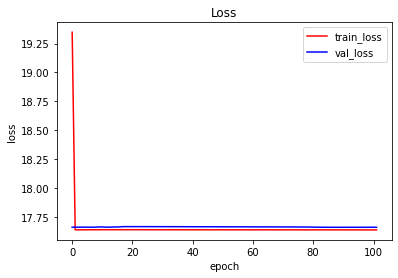

city: dearborn
epoch 0 train_loss: 21.325342492942745 val_loss: 18.383602216877545
epoch 1 train_loss: 18.031467504841327 val_loss: 16.177020127017215
epoch 2 train_loss: 15.519229937747495 val_loss: 14.431133400332165
epoch 3 train_loss: 14.12207034285695 val_loss: 13.332713689024592
epoch 4 train_loss: 13.25029236292447 val_loss: 12.552034625031569
epoch 5 train_loss: 13.062298625057851 val_loss: 12.436974684469547
epoch 6 train_loss: 13.007163295043185 val_loss: 12.370577019082083
epoch 7 train_loss: 12.959095862700256 val_loss: 12.387857542510607
epoch 8 train_loss: 12.97513478181725 val_loss: 12.946301296317353
epoch 9 train_loss: 13.062745050125976 val_loss: 12.640215986170263
epoch 10 train_loss: 12.74034580102611 val_loss: 12.26365466517235
epoch 11 train_loss: 12.908053349709379 val_loss: 12.263058595816897
epoch 12 train_loss: 12.869605663287928 val_loss: 12.30506308175837
epoch 13 train_loss: 12.833926739592627 val_loss: 12.241443890354454
epoch 14 train_loss: 12.87885203086

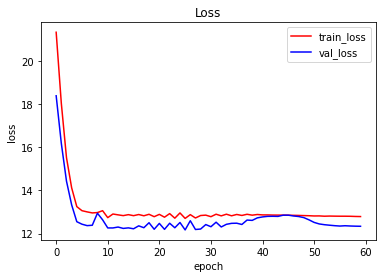

city: washington-dc
epoch 0 train_loss: 20.105745850789987 val_loss: 17.207808659907883
epoch 1 train_loss: 17.197866037842935 val_loss: 17.199936526827024
epoch 2 train_loss: 17.197162026649007 val_loss: 17.199835623049797
epoch 3 train_loss: 17.19716156136041 val_loss: 17.199779683235008
epoch 4 train_loss: 17.197216154371237 val_loss: 17.199727023158516
epoch 5 train_loss: 17.197292345702063 val_loss: 17.19970439463147
epoch 6 train_loss: 17.19738510002947 val_loss: 17.19975447502959
epoch 7 train_loss: 17.197447681715207 val_loss: 17.199926504795215
epoch 8 train_loss: 17.197464072855542 val_loss: 17.200010574315233
epoch 9 train_loss: 17.197498634148776 val_loss: 17.200224358537874
epoch 10 train_loss: 17.197558614711383 val_loss: 17.200693427464394
epoch 11 train_loss: 17.197645452447905 val_loss: 17.201361655991757
epoch 12 train_loss: 17.197725277642306 val_loss: 17.201285226987288
epoch 13 train_loss: 17.197770395893116 val_loss: 17.20124886727744
epoch 14 train_loss: 17.19778

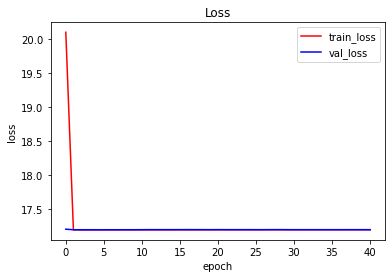

city: palo-alto
epoch 0 train_loss: 19.27712465143079 val_loss: 18.183049334218477
epoch 1 train_loss: 18.082116275652783 val_loss: 18.02489206606971
epoch 2 train_loss: 17.980007337354152 val_loss: 17.91846397623701
epoch 3 train_loss: 17.95518367054009 val_loss: 17.91611557800841
epoch 4 train_loss: 17.952618432376962 val_loss: 17.91308227192467
epoch 5 train_loss: 17.938885774754272 val_loss: 17.734139163776902
epoch 6 train_loss: 17.0136556638698 val_loss: 16.514462641517095
epoch 7 train_loss: 16.276678819907524 val_loss: 16.035022152245695
epoch 8 train_loss: 16.082565558416633 val_loss: 15.868796836975772
epoch 9 train_loss: 15.922018417986418 val_loss: 15.623202820543415
epoch 10 train_loss: 15.32611952152269 val_loss: 14.923626515765049
epoch 11 train_loss: 14.151179806776296 val_loss: 13.690080277430253
epoch 12 train_loss: 13.493860600461824 val_loss: 13.135952216040316
epoch 13 train_loss: 13.02783262337151 val_loss: 12.627833105149772
epoch 14 train_loss: 12.70925041662415

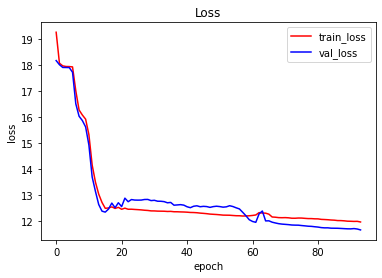

CPU times: user 21min 44s, sys: 17.1 s, total: 22min 1s
Wall time: 22min


In [7]:
%%time
import pickle
#train city models
for city in cities:
    print('city: ' + city)
    batch_sz = 128  # batch size
    train_dataset  = ArgoverseDataset(city = city, split = 'train')
    train_loader = DataLoader(train_dataset,batch_size=batch_sz)
    val_dataset = ArgoverseDataset(city = city, split = 'val')
    val_loader = DataLoader(val_dataset,batch_size=batch_sz)
    
    pred = Pred()
    opt = optim.Adam(pred.parameters(), lr=1e-4)
    train(pred, opt, train_dataset, train_loader, val_dataset, val_loader)
#     pickle.dump(pred, open('models/ta_model_baseline_' + city + '_large', 'wb'))

In [8]:
import pandas as pd
cols = np.array(['v' + str(i) for i in range(120)])
all_preds = []
for city in cities:
    load_pred = pickle.load(open('models/mlp_9_layer_' + city + '_large', 'rb'))
    test_dataset = get_city_trajectories(city = city, split = 'test')
    device = torch.device('cuda:0')
    load_pred = load_pred.to(device)
    preds = load_pred(torch.from_numpy(test_dataset[0]).to(device))
    preds_reshaped = preds.reshape(preds.size()[0], 120)
    preds_numpy = preds_reshaped.cpu().detach().numpy()
    ids = np.array([str(i) + '_' + city for i in range(len(preds_numpy))])
    predictions = pd.DataFrame(preds_numpy, columns=cols)
    predictions.insert(0, 'ID', ids)
    all_preds.append(predictions)
    
all_predictions = pd.concat(all_preds, ignore_index = True)

In [9]:
all_predictions

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,-26.216644,-564.477295,-27.124205,-563.928345,-25.679943,-563.908325,-26.517328,-563.160828,-25.736412,...,-25.823902,-565.559937,-25.479321,-566.010071,-25.529182,-565.845642,-24.142647,-565.292847,-25.422909,-564.934692
1,1_austin,-342.074585,-12.228256,-342.429932,-13.662514,-342.750092,-14.004765,-342.207245,-12.127224,-343.007751,...,-344.053162,-12.582468,-342.671997,-11.546379,-344.043121,-11.590363,-342.767212,-12.388306,-342.887939,-11.617770
2,2_austin,53.204571,-249.683472,53.354614,-249.364319,53.122166,-249.513855,53.576584,-249.831848,53.457779,...,53.178375,-249.508606,53.124374,-249.512329,53.336658,-249.367172,53.396832,-249.542908,53.346054,-249.115707
3,3_austin,-103.318542,1788.981934,-104.858246,1788.565430,-102.228088,1783.768555,-104.739227,1787.828979,-102.898727,...,-103.278465,1790.244385,-101.750839,1793.082520,-103.474777,1794.723145,-101.185944,1791.004761,-101.350952,1791.958984
4,4_austin,1230.697266,-661.494568,1231.032715,-661.287842,1231.106934,-661.118164,1230.576660,-660.588806,1230.994385,...,1225.291382,-657.814575,1224.657471,-657.661987,1224.585327,-657.707153,1225.034668,-657.544739,1224.550293,-657.724854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29838,1681_palo-alto,-1373.898560,-474.449493,-1373.234131,-479.559326,-1370.244873,-475.791138,-1370.453003,-476.620483,-1371.610718,...,-1370.773071,-478.690826,-1374.855957,-480.402893,-1369.189575,-478.210938,-1371.920898,-476.755188,-1370.006836,-478.537354
29839,1682_palo-alto,133.257828,-21.180212,133.267197,-20.589529,133.464951,-22.105749,133.179291,-21.816444,133.271393,...,133.285278,-21.222801,133.859680,-20.551605,133.208115,-20.899956,132.854492,-21.313606,132.982864,-22.142956
29840,1683_palo-alto,-1451.680298,2156.428711,-1449.262451,2155.852783,-1452.724121,2157.607666,-1452.644531,2156.820312,-1453.913452,...,-1452.439941,2156.607422,-1452.213379,2158.315918,-1452.416626,2159.484375,-1451.698242,2158.794189,-1453.478516,2159.478760
29841,1684_palo-alto,1025.651611,1400.174072,1028.980957,1397.451416,1025.375000,1397.145874,1024.595581,1398.559204,1024.296509,...,1022.164429,1399.026367,1023.696655,1399.079834,1022.458618,1402.575439,1025.046387,1402.616943,1021.285889,1401.898804


In [10]:
all_predictions.to_csv('out.csv', index=False)

In [11]:
pd.read_csv('out.csv')

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,-26.216644,-564.477300,-27.124205,-563.928340,-25.679943,-563.908300,-26.517328,-563.160800,-25.736412,...,-25.823902,-565.559940,-25.479320,-566.010100,-25.529182,-565.845640,-24.142647,-565.292850,-25.422909,-564.934700
1,1_austin,-342.074600,-12.228256,-342.429930,-13.662514,-342.750100,-14.004765,-342.207240,-12.127224,-343.007750,...,-344.053160,-12.582468,-342.672000,-11.546379,-344.043120,-11.590363,-342.767200,-12.388306,-342.887940,-11.617770
2,2_austin,53.204570,-249.683470,53.354614,-249.364320,53.122166,-249.513850,53.576584,-249.831850,53.457780,...,53.178375,-249.508600,53.124374,-249.512330,53.336660,-249.367170,53.396830,-249.542910,53.346054,-249.115700
3,3_austin,-103.318540,1788.981900,-104.858246,1788.565400,-102.228090,1783.768600,-104.739230,1787.829000,-102.898730,...,-103.278465,1790.244400,-101.750840,1793.082500,-103.474780,1794.723100,-101.185940,1791.004800,-101.350950,1791.959000
4,4_austin,1230.697300,-661.494570,1231.032700,-661.287840,1231.106900,-661.118160,1230.576700,-660.588800,1230.994400,...,1225.291400,-657.814600,1224.657500,-657.662000,1224.585300,-657.707150,1225.034700,-657.544740,1224.550300,-657.724850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29838,1681_palo-alto,-1373.898600,-474.449500,-1373.234100,-479.559330,-1370.244900,-475.791140,-1370.453000,-476.620480,-1371.610700,...,-1370.773100,-478.690830,-1374.856000,-480.402900,-1369.189600,-478.210940,-1371.920900,-476.755200,-1370.006800,-478.537350
29839,1682_palo-alto,133.257830,-21.180212,133.267200,-20.589529,133.464950,-22.105750,133.179290,-21.816444,133.271400,...,133.285280,-21.222801,133.859680,-20.551605,133.208110,-20.899956,132.854490,-21.313606,132.982860,-22.142956
29840,1683_palo-alto,-1451.680300,2156.428700,-1449.262500,2155.852800,-1452.724100,2157.607700,-1452.644500,2156.820300,-1453.913500,...,-1452.440000,2156.607400,-1452.213400,2158.316000,-1452.416600,2159.484400,-1451.698200,2158.794200,-1453.478500,2159.478800
29841,1684_palo-alto,1025.651600,1400.174100,1028.981000,1397.451400,1025.375000,1397.145900,1024.595600,1398.559200,1024.296500,...,1022.164400,1399.026400,1023.696660,1399.079800,1022.458600,1402.575400,1025.046400,1402.617000,1021.285900,1401.898800
